In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
#load data
data_folder = Path("C:/Users/faraz/Documents/VSCode/Python/")
train_file = data_folder/"train.csv"
raw_data = pd.read_csv(train_file)

In [3]:
#clean data where either a column has too many similar values or too many different values
df = raw_data.drop(columns= 'Id', axis= 1)
limitPer = len(df) * .80
df = df.dropna(thresh=limitPer,axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
freq = 0.9
spread = 0.7
for column in df:
    if df[column].value_counts(normalize= True, dropna= False).values[0] > freq or len(pd.unique(df[column])) > spread * len(df[column]):
        print('removed', column)
        df.drop(columns= column, axis= 1, inplace= True)
        

removed Bedingung2
removed Versorgung
removed Grundstuecksgroesse
removed Gelaendekontur
removed Gelaendeneigung
removed Strassentyp
removed Dachmeterial
removed Kellerzustand
removed KellerHalbbadezimmer
removed GeringequalitaetFlaeche
removed Funktionalitaet
removed Kuechen
removed Heizung
removed Klimalanlage
removed Elektrik
removed 3JahreszeitenVerandaflaeche
removed AbgeschirmteVerandaflaeche
removed Poolflaeche
removed Garagenqualitaet
removed Garagenzustand
removed EinfahrtGepflastert
removed SondermerkmalWert


In [4]:
#encoding string data to readable data for training
dfle = df
encoded_columns = []
le = LabelEncoder()
for column in dfle:
    if dfle[column].dtypes == 'object':
        dfle[column] = le.fit_transform(dfle[column].astype(str))

for column, row in dfle.items():
    if not dfle[column].dtypes == 'object':
        if any(row.values > np.finfo(np.float64).max):
            print('Value too large for float64')

In [5]:
#finding the best features
features_x = dfle.drop(columns= 'Verkaufspreis', axis= 1)
features_y = dfle.Verkaufspreis
features_x = features_x.astype('int')
features_y = features_y.astype('int')

bestfeatures = SelectKBest(score_func=chi2, k=14)
fit = bestfeatures.fit(features_x,features_y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']

print(featureScores.nlargest(14,'Score'))

                       Feature         Score
32               2Stockflaeche  40867.646641
24       Kellerbereichgroesse1  40788.173750
26       Kellerbereichgroesse2  30086.453655
15            Mauerwerkflaeche  29427.249260
27     KellerbereichgroesseNAu  24021.471295
3               Wohnungsklasse  20871.317716
30     OberirdischeWohnflaeche  17879.027892
28     KellerbereichgroesseGes  15773.921716
31               1Stockflaeche  13543.165391
40             Holzdeckflaeche  11162.026865
42  GeschlosseneVerandaflaeche  11066.171149
47              Garagenflaeche   7238.536610
41        OffeneVerandaflaeche   6620.288289
1                Nachbarschaft   2594.938103


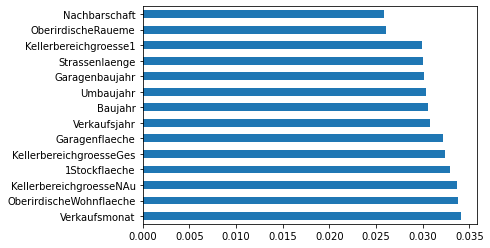

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(features_x,features_y)
feat_importances = pd.Series(model.feature_importances_, index=features_x.columns)
feat_importances.nlargest(14).plot(kind='barh')
plt.show()

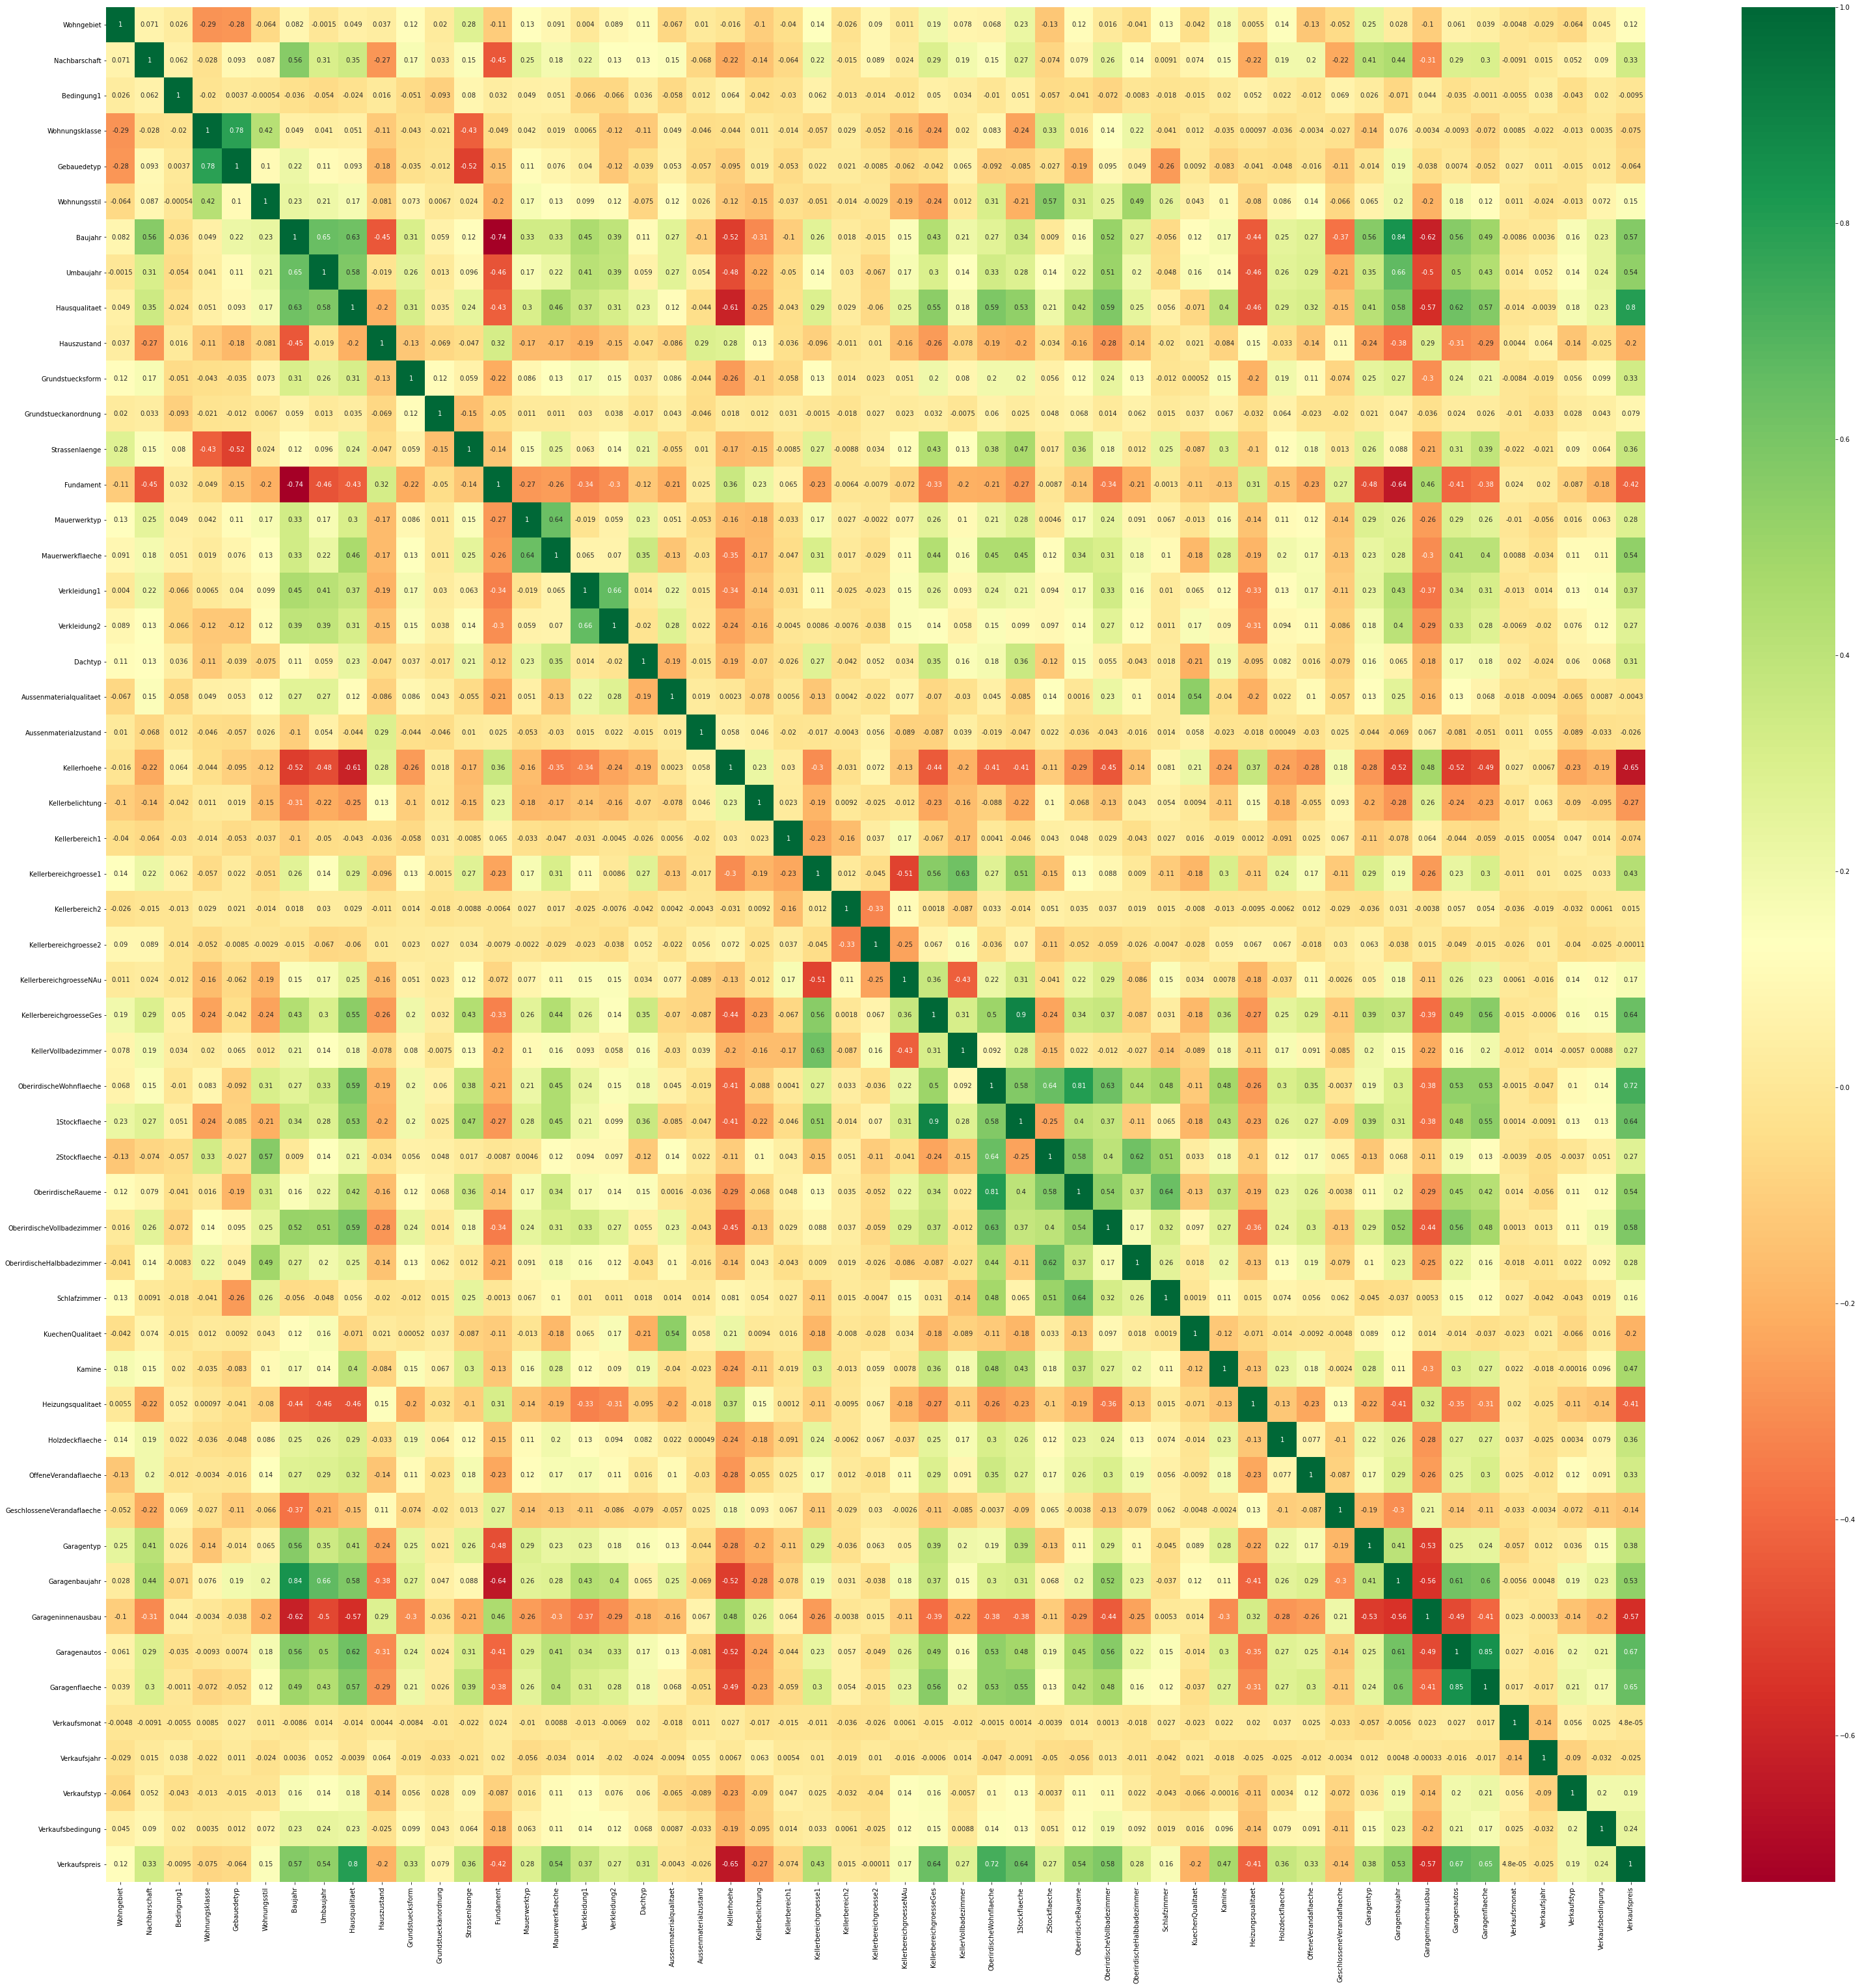

In [7]:
import seaborn as sns
corrmat = dfle.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(53,53))
g=sns.heatmap(dfle[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
cor_target = abs(corrmat['Verkaufspreis'])
final_features = cor_target[cor_target>0.6]

X = dfle[final_features.index].drop(columns= 'Verkaufspreis', axis= 1)
Y = dfle.Verkaufspreis
column_labels = X.columns.values

Text(0, 0.5, 'cumulative explained variance')

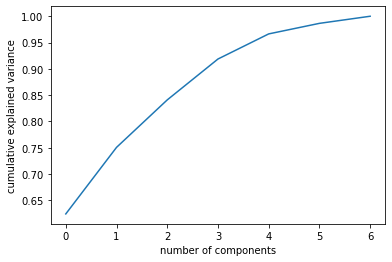

In [9]:
#finding the best number of components
scaled_x = scale(X)
pca = decomposition.PCA().fit(scaled_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [10]:
pca = decomposition.PCA(n_components=5)
pca.fit(scaled_x)
scores = pca.transform(scaled_x)

In [11]:
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
scores_df = pd.concat([scores_df, dfle.Verkaufspreis], axis=1)

In [12]:
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=column_labels)

<AxesSubplot:>

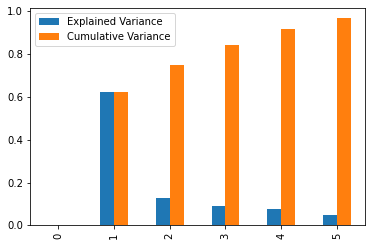

In [13]:
explained_variance = pca.explained_variance_ratio_
explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=4))
pc_df = pd.DataFrame(['','PC1', 'PC2', 'PC3', 'PC4', 'PC5'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])
df_explained_variance = pd.concat([pc_df, explained_variance_df, cumulative_variance_df], axis=1)
df_explained_variance.plot(kind= 'bar')

In [14]:
#splitting the dataset
pca_X = scores_df.drop(columns= 'Verkaufspreis', axis= 1)
pca_Y = scores_df.Verkaufspreis

X_train, X_test, Y_train, Y_test = train_test_split(pca_X, pca_Y, test_size= 0.2, random_state= 20)

In [15]:
#training the model with linear regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
print(lr.coef_)

[ 28872.72554322  -5546.60367175 -13243.05062425  15730.22977487
  -8187.97772326]


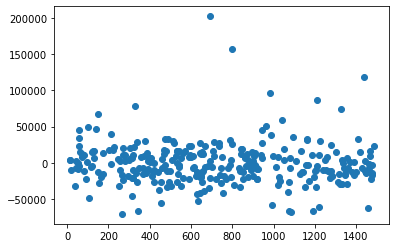

In [16]:
#Error margin
Y_test_predict = lr.predict(X_test)
g=plt.plot((Y_test - Y_test_predict), marker= 'o', linestyle='')

In [19]:
#random forest
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10)
regressor.fit(X_train, Y_train)
Y_pred= regressor.predict(X_test)

print('Accuracy: ', regressor.score(X_test, Y_test))

Accuracy:  0.8908637747411755
